# Part1

In [1]:
from __future__ import unicode_literals

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname=r"/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/msyh.ttf")

import numpy as np

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis#CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

False    343
True      70
Name: 是否有裂纹, dtype: int64


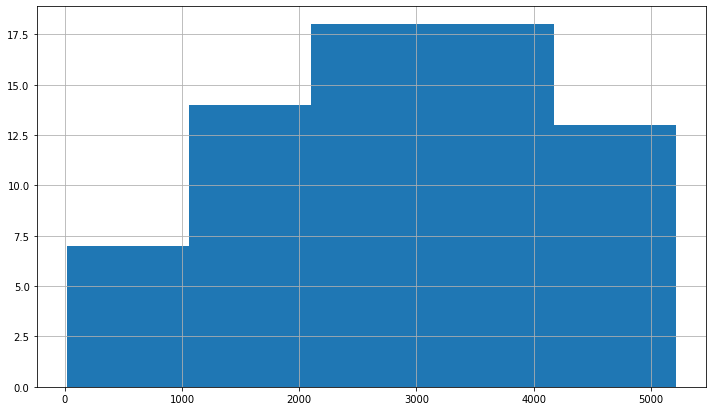

In [44]:
plt.rcParams["figure.figsize"] = [12,7]
data1 = pd.read_csv("热交换芯数据统计最终版.csv", encoding = "GB2312")

data1 = data1[data1["件号"]=="182820-3"]

#data1 = data1[data1["部件装上使用小时数"]!="00:00"]
data1["换芯后出现裂纹的循环"] = data1["换芯后出现裂纹的循环"].astype(int)
data1 = data1[data1["换芯后出现裂纹的循环"]>0]


data1["是否有裂纹"] = data1["是否有裂纹"].astype(bool)
#data1[data1["是否有裂纹"]="Y"] = 1
#data1[data1["是否有裂纹"]="N"] = 0

#data1["IsPlanned"] = data1["非计划"]=="X"
print(data1["是否有裂纹"].value_counts())
data_y = data1[["是否有裂纹", "换芯后出现裂纹的循环"]]
data_y[data_y["是否有裂纹"]==True]["换芯后出现裂纹的循环"].hist(bins=5)#, range=(0,60000))

'''
data1["IsPlaneNew"] = data1["部件装上飞行小时数"]=="00:00"
data1["IsPartNew"] = data1["部件装上使用小时数"]=="00:00"
def CheckNew(p1,p2):
    if p1 and p2:
        return "PlaneNew-PartNew"
    elif p1 and not p2:
        return "PlaneNew-PartOld"
    elif not p1 and p2:
        return "PlaneOld-PartNew"
    elif not p1 and not p2:
        return "PlaneOld-PartOld"

#print([CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()])
data1["PlanePartType"] = [CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()]
'''


data1["完成时间"] = pd.to_datetime(data1["完成时间"])
data1["完成时间年度"] = data1["完成时间"].dt.year

di = {"成都凯泽": "凯泽"}
data1.replace({"焊接厂家": di}, inplace=True)
di = {"新乡平原": "新乡"}
data1.replace({"焊接厂家": di}, inplace=True)
di = {"河南新乡换芯": "新乡"}
data1.replace({"焊接厂家": di}, inplace=True)
#data1["焊接厂家"].fillna("Unknown", inplace=True)

#data1["FH TSN"].fillna("00:00", inplace=True)
data1["换芯时TSN CY"] = data1["换芯时TSN CY"].astype(int)
data1["换芯时 TSN FH"] = data1["换芯时 TSN FH"].astype(int)

data1["总装机循环"] = data1["总装机循环"].astype(int)
data1["总装机时间"] = data1["总装机时间"].astype(int)

data1["换芯时TSN CY-Range"] = pd.cut(data1['换芯时TSN CY'], 8)
#data1["部件装上飞行循环数-Range"] = pd.cut(data1['部件装上飞行循环数'], 8)
data1["换芯时 TSN FH-Range"] = pd.cut(data1['换芯时 TSN FH'], 8)
#data1["部件装上使用循环数-Range"] = pd.cut(data1['部件装上使用循环数'], 8)
data1["总装机循环-Range"] = pd.cut(data1['总装机循环'], 8)
data1["总装机时间-Range"] = pd.cut(data1['总装机时间'], 8)

#data_x = data1[["机型","制造序列号","机号","参考类型","指令类型","序号","拆换原因","部件装上飞行循环数","部件装上使用循环数",
#                "部件拆下飞行循环数","部件拆下使用循环数","装上序号","最近送修公司","CY TSN","FH TSN"]]
#data_x = data1[["机型","参考类型","指令类型","拆换原因","部件装上飞行循环数","部件装上使用循环数",
#                "部件拆下飞行循环数","部件拆下使用循环数","CY TSN","FH TSN"]]
data_x = data1[["件号","完成时间年度","换芯时TSN CY-Range","换芯时 TSN FH-Range","总装机循环-Range", "总装机时间-Range", 
                "焊接厂家"]]

Text(0.5, 0, 'time $t$')

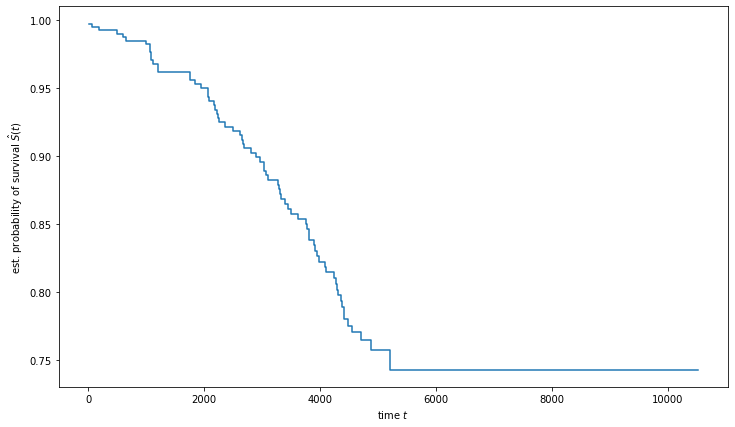

In [45]:
#"是否有裂纹", "换芯后循环"
time, survival_prob = kaplan_meier_estimator(data_y["是否有裂纹"], data_y["换芯后出现裂纹的循环"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

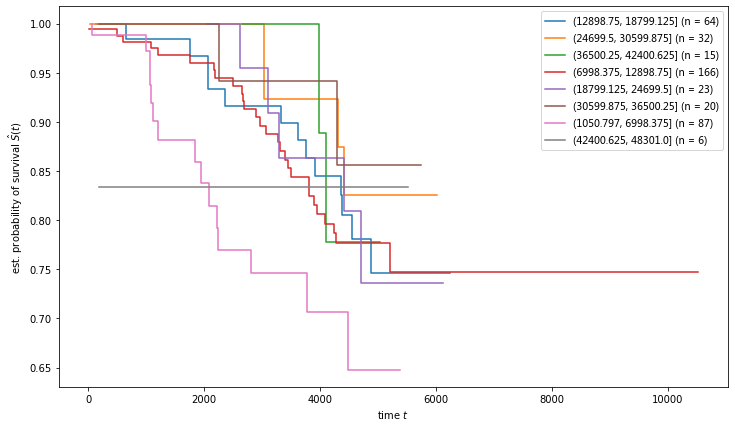

In [46]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "换芯时TSN CY-Range"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

y = data_y
x = data_x

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["是否有裂纹"][mask],
                                                           y["换芯后出现裂纹的循环"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

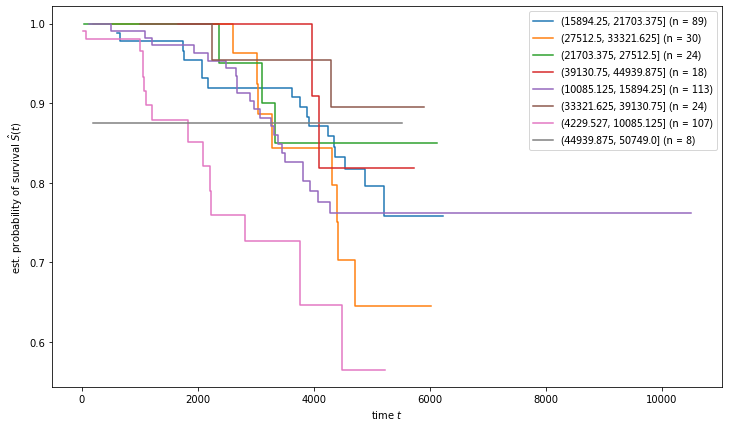

In [47]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "总装机循环-Range"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

y = data_y
x = data_x

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["是否有裂纹"][mask],
                                                           y["换芯后出现裂纹的循环"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

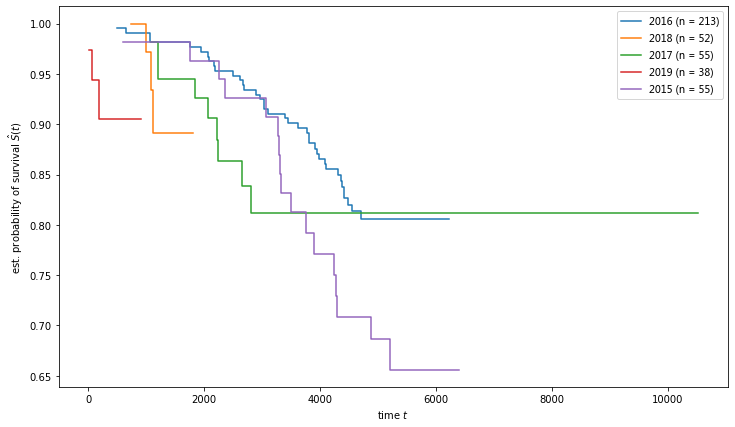

In [48]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "完成时间年度"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

y = data_y
x = data_x

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["是否有裂纹"][mask],
                                                           y["换芯后出现裂纹的循环"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

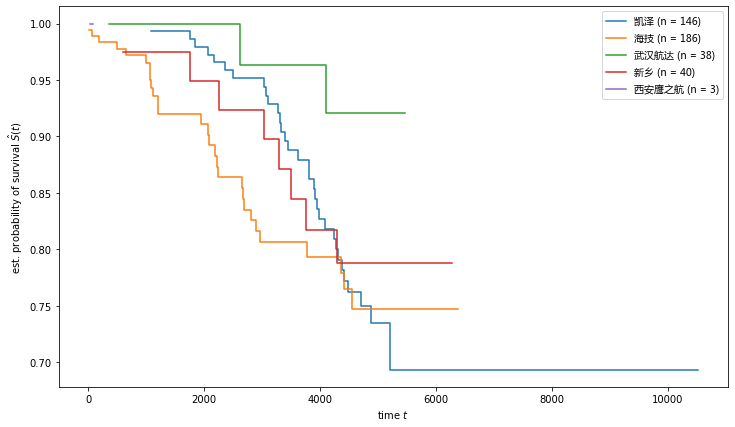

In [49]:
# "机型","拆换年度","部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range", "最近送修公司"
#col = "机型"
#col = "参考类型"
col = "焊接厂家"
#col = "安装年度"
#col = "机型"

#print((data_x["最近送修公司"]!="上海航新") & (data_x["最近送修公司"]!="PP"))

filter1 = (data_x["焊接厂家"]!="西安鹰之航1") & (data_x["焊接厂家"]!="广州航新") & (data_x["焊接厂家"]!="上海航新")
y = data_y[filter1]
x = data_x[filter1]

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["是否有裂纹"][mask],
                                                           y["换芯后出现裂纹的循环"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right", prop=font)

In [50]:
#data_x.select_dtypes(exclude=['int','int64' 'float']).columns
data_x.describe()

,完成时间年度
count,413.000000
mean,2016.527845
std,1.150063
min,2015.000000
25%,2016.000000
50%,2016.000000
75%,2017.000000
max,2019.000000


In [51]:
#"部件装上飞行小时数-Range","部件装上飞行循环数-Range","部件装上使用小时数-Range","部件装上使用循环数-Range","CY TSN-Range","FH TSN-Range",
#
x = data_x.copy()
cat_features = ["换芯时TSN CY-Range", "总装机循环-Range","完成时间年度","焊接厂家"]

for col in cat_features:
    x[col] = x[col].astype('category')

data_x_numeric = OneHotEncoder().fit_transform(x[cat_features])
data_x_numeric.head()

,"换芯时TSN CY-Range=(6998.375, 12898.75]","换芯时TSN CY-Range=(12898.75, 18799.125]","换芯时TSN CY-Range=(18799.125, 24699.5]","换芯时TSN CY-Range=(24699.5, 30599.875]","换芯时TSN CY-Range=(30599.875, 36500.25]","换芯时TSN CY-Range=(36500.25, 42400.625]","换芯时TSN CY-Range=(42400.625, 48301.0]","总装机循环-Range=(10085.125, 15894.25]","总装机循环-Range=(15894.25, 21703.375]","总装机循环-Range=(21703.375, 27512.5]",...,"总装机循环-Range=(39130.75, 44939.875]","总装机循环-Range=(44939.875, 50749.0]",完成时间年度=2016,完成时间年度=2017,完成时间年度=2018,完成时间年度=2019,焊接厂家=新乡,焊接厂家=武汉航达,焊接厂家=海技,焊接厂家=西安鹰之航
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
null_columns=data1.columns[data1.isnull().any()]
data1[null_columns].isnull().sum()

拆下后发现裂纹CY TSN    343
拆下后发现裂纹FH TSN    343
换芯后送修几次            5
送修报告是否有裂纹         57
其他               389
dtype: int64

In [53]:
data_x_numeric

,"换芯时TSN CY-Range=(6998.375, 12898.75]","换芯时TSN CY-Range=(12898.75, 18799.125]","换芯时TSN CY-Range=(18799.125, 24699.5]","换芯时TSN CY-Range=(24699.5, 30599.875]","换芯时TSN CY-Range=(30599.875, 36500.25]","换芯时TSN CY-Range=(36500.25, 42400.625]","换芯时TSN CY-Range=(42400.625, 48301.0]","总装机循环-Range=(10085.125, 15894.25]","总装机循环-Range=(15894.25, 21703.375]","总装机循环-Range=(21703.375, 27512.5]",...,"总装机循环-Range=(39130.75, 44939.875]","总装机循环-Range=(44939.875, 50749.0]",完成时间年度=2016,完成时间年度=2017,完成时间年度=2018,完成时间年度=2019,焊接厂家=新乡,焊接厂家=武汉航达,焊接厂家=海技,焊接厂家=西安鹰之航
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
# Not RUN
#data_y = data_y.as_matrix()
y = data_y.to_records(index=False)
estimator = CoxPHSurvivalAnalysis() #CoxnetSurvivalAnalysis()
estimator.fit(data_x_numeric, y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [55]:
# Not RUN
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(y["IsPlanned"], y["部件本次装机使用小时"], prediction)
print(result[0])
result = concordance_index_ipcw(y, y, prediction)
print(result[0])

ValueError: no field of name IsPlanned

In [56]:
# Not RUN
prediction

array([ -1.56236041,  -1.48652579,  -2.1157584 ,  -1.56236041,
        -1.37557452,  -1.15884974,  -1.56693137,  -1.66151971,
        -1.48652579,  -2.00841126,  -1.52450833,  -1.7978389 ,
        -0.83885484,  -1.29166539,  -2.08645474,  -1.87281338,
        -0.83899147,  -0.93357981,  -0.83899147,  -0.83899147,
        -2.50871912,  -0.93357981,  -3.19058985,  -3.67813891,
        -2.60330746,  -2.50871912,  -3.67813891,  -2.50871912,
        -3.04223317,  -0.52186538,  -1.56236041,  -1.39570996,
        -1.56236041,  -1.39570996,  -2.56512975,  -2.50871912,
        -1.65694875,  -1.84838388,  -1.56236041,  -1.65694875,
        -1.56236041,  -1.87281338,  -1.56236041,  -2.56512975,
        -1.56236041,  -1.56236041,  -1.56236041,  -1.65694875,
        -1.56236041,  -2.7317802 ,  -2.7317802 ,  -1.56236041,
        -0.52186538,  -1.56236041,  -1.56236041,  -1.56236041,
        -1.56236041,  -1.65694875,  -1.56236041,  -1.56693137,
        -1.65694875,  -1.65694875,  -1.56236041,  -2.01

In [57]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

gbSA = ComponentwiseGradientBoostingSurvivalAnalysis(n_estimators=300, learning_rate=0.2)
gbSA.fit(data_x_numeric, y)

ComponentwiseGradientBoostingSurvivalAnalysis(dropout_rate=0,
                       learning_rate=0.2, loss='coxph', n_estimators=300,
                       random_state=None, subsample=1.0, verbose=0)

In [58]:
prediction2 = gbSA.predict(data_x_numeric)
#prediction2 = np.mean(prediction2, axis=1)
result = concordance_index_censored(y["是否有裂纹"], y["换芯后出现裂纹的循环"], prediction2)
print(result[0])
#result = concordance_index_ipcw(y, y, prediction)
#print(result[0])

0.670421924930943


In [59]:
#gbSA.feature_importances_

In [60]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxnetSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

完成时间年度=2016                              0.590343
焊接厂家=海技                                  0.565889
焊接厂家=武汉航达                                0.533689
总装机循环-Range=(15894.25, 21703.375]        0.533147
完成时间年度=2019                              0.529221
完成时间年度=2017                              0.526296
总装机循环-Range=(33321.625, 39130.75]        0.523669
换芯时TSN CY-Range=(24699.5, 30599.875]     0.521963
总装机循环-Range=(39130.75, 44939.875]        0.515328
完成时间年度=2018                              0.514353
换芯时TSN CY-Range=(30599.875, 36500.25]    0.514082
总装机循环-Range=(21703.375, 27512.5]         0.512430
换芯时TSN CY-Range=(12898.75, 18799.125]    0.511672
换芯时TSN CY-Range=(36500.25, 42400.625]    0.511076
换芯时TSN CY-Range=(18799.125, 24699.5]     0.507177
换芯时TSN CY-Range=(42400.625, 48301.0]     0.505281
焊接厂家=新乡                                  0.505227
换芯时TSN CY-Range=(6998.375, 12898.75]     0.504116
总装机循环-Range=(27512.5, 33321.625]         0.503466
总装机循环-Range=(10085.125, 15894.25]        0.503331


In [61]:
x_new = data_x_numeric.loc[[46,77,200,411]]
#print(x_new)
data_x.loc[[46,77,200,411]]

,件号,完成时间年度,换芯时TSN CY-Range,换芯时 TSN FH-Range,总装机循环-Range,总装机时间-Range,焊接厂家
46,182820-3,2016,"(12898.75, 18799.125]","(21791.25, 31538.375]","(15894.25, 21703.375]","(28231.25, 37948.875]",凯泽
77,182820-3,2016,"(6998.375, 12898.75]","(21791.25, 31538.375]","(15894.25, 21703.375]","(28231.25, 37948.875]",凯泽
200,182820-3,2016,"(1050.797, 6998.375]","(2219.023, 12044.125]","(4229.527, 10085.125]","(18513.625, 28231.25]",海技
411,182820-3,2015,"(6998.375, 12898.75]","(12044.125, 21791.25]","(10085.125, 15894.25]","(18513.625, 28231.25]",新乡


In [62]:
y[[46,77,200,411]]

rec.array([(False, 4613), (False, 4000), ( True, 2092), (False, 5028)],
          dtype=[('是否有裂纹', '?'), ('换芯后出现裂纹的循环', '<i8')])

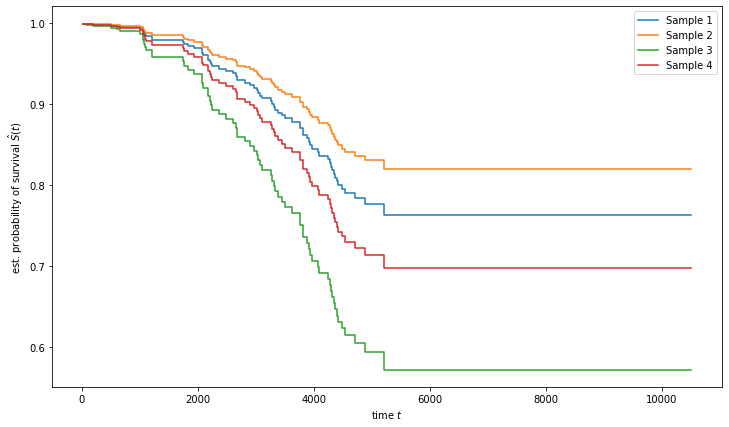

In [63]:
pred_surv = estimator.predict_survival_function(x_new)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [64]:
pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [65]:
param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] -3)}
gcv = GridSearchCV(pipe, param_grid=param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(x, y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

dropped categorical variable '件号', because it has only 1 values
/root/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


AttributeError: Can only use .cat accessor with a 'category' dtype

In [66]:
pipe.set_params(**gcv.best_params_)
pipe.fit(x, y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Part2

In [67]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

In [68]:
data_x = data1[["换芯时TSN CY","总装机循环","完成时间年度"]]

In [69]:
def df_to_sarray(df):
    """
    Convert a pandas DataFrame object to a numpy structured array.
    This is functionally equivalent to but more efficient than
    np.array(df.to_array())

    :param df: the data frame to convert
    :return: a numpy structured array representation of df
    """

    v = df.values
    cols = df.columns

    if False:  # python 2 needs .encode() but 3 does not
        types = [(cols[i].encode(), df[k].dtype.type) for (i, k) in enumerate(cols)]
    else:
        types = [(cols[i], df[k].dtype.type) for (i, k) in enumerate(cols)]
    dtype = np.dtype(types)
    z = np.zeros(v.shape, dtype)
    for (i, k) in enumerate(z.dtype.names):
        z[:,i] = v[:, i]
    return z

In [70]:
y = data_y.to_records(index=False)
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2)#, random_state=1)
x_train = x_train.values
x_test = x_test.values

In [71]:
y_events_train = y_train[y_train['是否有裂纹']==False]
train_min, train_max = y_events_train["换芯后出现裂纹的循环"].min(), y_events_train["换芯后出现裂纹的循环"].max()

y_events_test = y_test[y_test['是否有裂纹']==False]
test_min, test_max = y_events_test["换芯后出现裂纹的循环"].min(), y_events_test["换芯后出现裂纹的循环"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

AssertionError: time range or test data is not within time range of training data.

In [72]:
times = np.percentile(data_y["换芯后出现裂纹的循环"], np.linspace(5, 95, 15))
print(times)

[ 362.          900.2        1116.57142857 1755.57142857 2618.42857143
 3104.71428571 3525.31428571 4000.         4386.62857143 4560.97142857
 4763.45714286 4923.65714286 5051.57142857 5247.22857143 5758.8       ]


In [73]:
import matplotlib
matplotlib.matplotlib_fname()

'/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

/root/anaconda2/envs/python3/lib/python3.6/site-packages/sksurv/metrics.py:430: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()
/root/anaconda2/envs/python3/lib/python3.6/site-packages/sksurv/metrics.py:430: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()
/root/anaconda2/envs/python3/lib/python3.6/site-packages/sksurv/metrics.py:430: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()


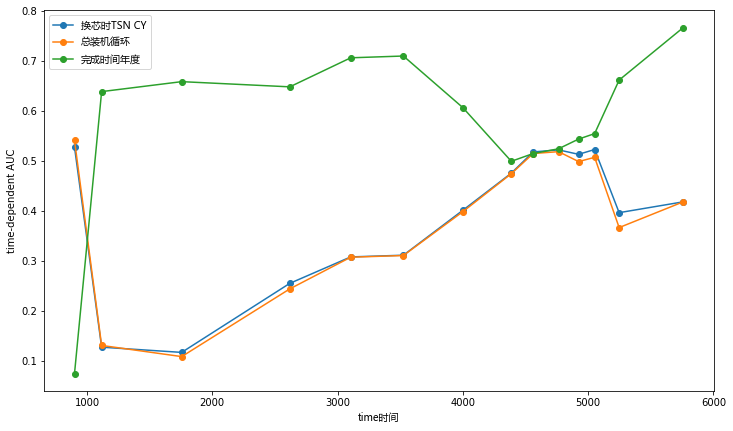

In [74]:
num_columns = ["换芯时TSN CY","总装机循环","完成时间年度"]
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    
    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.legend(prop = font)
    
    plt.xlabel("time时间",fontproperties=font)
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

# Part3

In [75]:
data_x = data1[["换芯时TSN CY-Range","总装机循环-Range","完成时间年度","焊接厂家","换芯时TSN CY", "总装机循环"]]

cat_features = ["换芯时TSN CY-Range", "总装机循环-Range", "完成时间年度","焊接厂家"]

for col in cat_features:
    data_x[col] =data_x[col].astype('category')

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
times = np.percentile(data_y["换芯后出现裂纹的循环"], np.linspace(5, 95, 15))
print(times)

[ 362.          900.2        1116.57142857 1755.57142857 2618.42857143
 3104.71428571 3525.31428571 4000.         4386.62857143 4560.97142857
 4763.45714286 4923.65714286 5051.57142857 5247.22857143 5758.8       ]


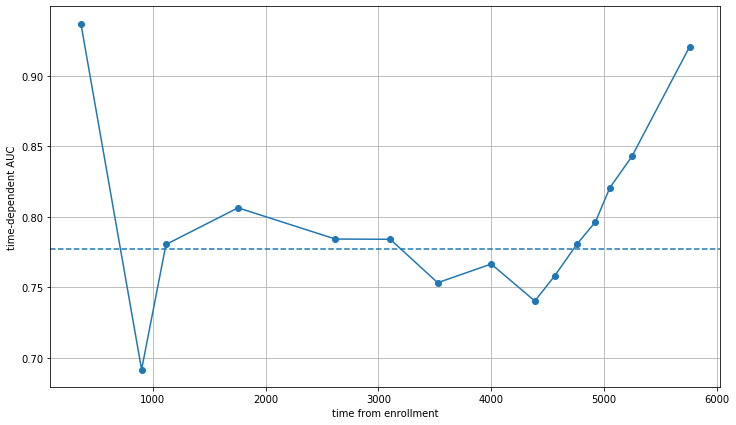

In [77]:
from sklearn.pipeline import make_pipeline

y = data_y.to_records(index=False)
va_x, va_y = data_x, y

cph = make_pipeline(OneHotEncoder(), CoxnetSurvivalAnalysis())
cph.fit(va_x, va_y)

# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), times)

plt.plot(times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("time from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# Part4

In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

In [79]:
data_x = data1[["换芯时TSN CY-Range","总装机循环-Range","完成时间年度","焊接厂家","换芯时TSN CY", "总装机循环"]]

cat_features = ["换芯时TSN CY-Range", "总装机循环-Range", "完成时间年度","焊接厂家"]

for col in cat_features:
    data_x[col] = data_x[col].astype('category')

/root/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
x = OneHotEncoder().fit_transform(data_x)#encode_categorical(data_x)

In [81]:
estimator = FastSurvivalSVM(optimizer="rbtree", max_iter=1000, tol=1e-6, random_state=0)

In [82]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['是否有裂纹'], y['换芯后出现裂纹的循环'], prediction)
    return result[0]

In [83]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=200, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, iid=False, refit=False,
                   cv=cv)

In [84]:
param_grid

{'alpha': array([2.44140625e-04, 9.76562500e-04, 3.90625000e-03, 1.56250000e-02,
        6.25000000e-02, 2.50000000e-01, 1.00000000e+00, 4.00000000e+00,
        1.60000000e+01, 6.40000000e+01, 2.56000000e+02, 1.02400000e+03,
        4.09600000e+03])}

In [85]:
import warnings
y = data_y.to_records(index=False)
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)

In [86]:
gcv.best_score_, gcv.best_params_

(0.610943856775587, {'alpha': 0.000244140625})

In [87]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):            
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

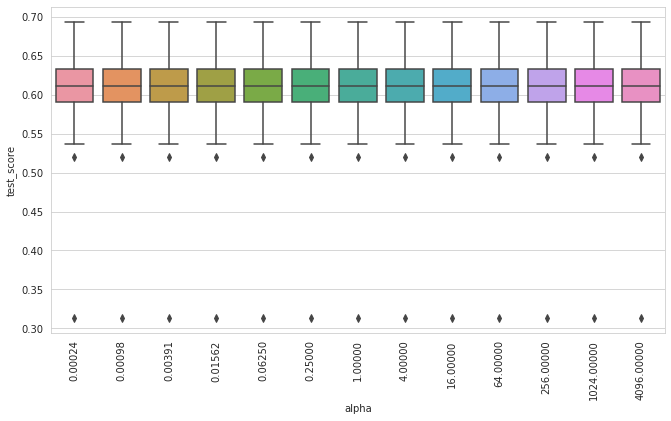

In [88]:
plot_performance(gcv)

In [89]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel

In [90]:
kernel_matrix = clinical_kernel(data_x)
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

In [91]:
kgcv = GridSearchCV(kssvm, param_grid, score_survival_model,
                    n_jobs=4, iid=False, refit=False,
                    cv=cv)

In [92]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
kgcv = kgcv.fit(kernel_matrix, y)

In [93]:
kgcv.best_score_, kgcv.best_params_

(0.6108361231472644, {'alpha': 0.000244140625})

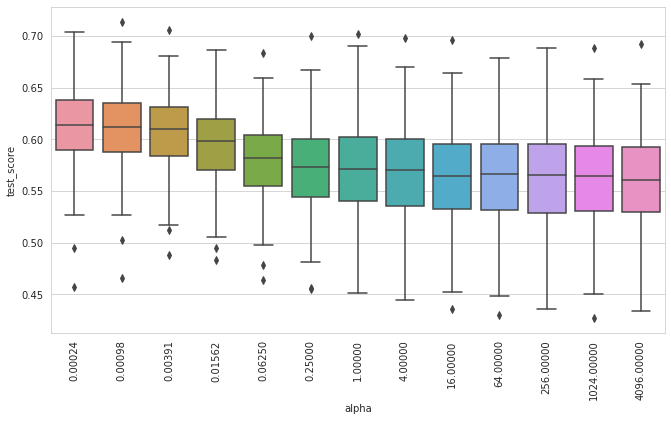

In [94]:
plot_performance(kgcv)